In this file I start by implementing a compressed sensing reconstruction approach. I want to have a well accepted classical method 
as a baseline for my later deep learning models.

In [1]:
import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"]= '2' #, this way I would choose GPU 3 to do the work

sys.path.append('../scripts')
sys.path.append('../models')

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
from Naive_CNN_3D import *
from output_statistics import *
import plotly.graph_objects as go

In [2]:
LowRank = False ####if set to true the model input is also low rank; if set to low the model input is full rank

if LowRank:
    Fully_Sampled = np.load('Low_Rank_8_P03-P08.npy')
else:
    Fully_Sampled = np.load('Ground_Truth/Full_Rank/P03-P08_truncated_k_space.npy')

print(Fully_Sampled.shape)
MASKS = np.load('masks.npy')

(22, 22, 21, 96, 8, 6)


1. Generate mask for spherical k-space

In [3]:
nx, ny, nz = 22, 22, 21
fixed_radius = 10

fixed_sphere_mask = fully_sampled_mask(fixed_radius,(nx, ny, nz))

sampled_point = np.sum(fixed_sphere_mask)

print("Number of sampled point")
print(sampled_point)

FT = fourier_transform(Fully_Sampled)
undersampled_FT = FT.copy()

Number of sampled point
4169


In [4]:
####
New_mask_1 = fixed_sphere_mask.copy()

#New_mask_1[:,:,20] = np.zeros((22,22))
New_mask_1[:,:,19] = np.zeros((22,22))
New_mask_1[:,:,18] = np.zeros((22,22))
#New_mask_1[:,:,17] = np.zeros((22,22))
New_mask_1[:,:,16] = np.zeros((22,22))
New_mask_1[:,:,15] = np.zeros((22,22))
#New_mask_1[:,:,14] = np.zeros((22,22))
New_mask_1[:,:,13] = np.zeros((22,22))
New_mask_1[:,:,12] = np.zeros((22,22))

#New_mask_1[:,:,8] = np.zeros((22,22))
New_mask_1[:,:,7] = np.zeros((22,22))
New_mask_1[:,:,6] = np.zeros((22,22))
#New_mask_1[:,:,5] = np.zeros((22,22))
New_mask_1[:,:,4] = np.zeros((22,22))
New_mask_1[:,:,3] = np.zeros((22,22))
#New_mask_1[:,:,2] = np.zeros((22,22))
New_mask_1[:,:,1] = np.zeros((22,22))
New_mask_1[:,:,0] = np.zeros((22,22))

AF = 4169/np.sum(New_mask_1)
print(AF)

####
New_mask_2 = fixed_sphere_mask.copy()

New_mask_2[:,:,20] = np.zeros((22,22))
#New_mask_2[:,:,19] = np.zeros((22,22))
New_mask_2[:,:,18] = np.zeros((22,22))
New_mask_2[:,:,17] = np.zeros((22,22))
#New_mask_2[:,:,16] = np.zeros((22,22))
New_mask_2[:,:,15] = np.zeros((22,22))
New_mask_2[:,:,14] = np.zeros((22,22))
#New_mask_2[:,:,13] = np.zeros((22,22))
New_mask_2[:,:,12] = np.zeros((22,22))

New_mask_2[:,:,8] = np.zeros((22,22))
#New_mask_2[:,:,7] = np.zeros((22,22))
New_mask_2[:,:,6] = np.zeros((22,22))
New_mask_2[:,:,5] = np.zeros((22,22))
#New_mask_2[:,:,4] = np.zeros((22,22))
New_mask_2[:,:,3] = np.zeros((22,22))
New_mask_2[:,:,2] = np.zeros((22,22))
#New_mask_2[:,:,1] = np.zeros((22,22))
New_mask_2[:,:,0] = np.zeros((22,22))

AF = 4169/np.sum(New_mask_2)
print(AF)

####
New_mask_3 = fixed_sphere_mask.copy()

New_mask_3[:,:,20] = np.zeros((22,22))
New_mask_3[:,:,19] = np.zeros((22,22))
#New_mask_3[:,:,18] = np.zeros((22,22))
New_mask_3[:,:,17] = np.zeros((22,22))
New_mask_3[:,:,16] = np.zeros((22,22))
#New_mask_3[:,:,15] = np.zeros((22,22))
New_mask_3[:,:,14] = np.zeros((22,22))
New_mask_3[:,:,13] = np.zeros((22,22))
#New_mask_3[:,:,12] = np.zeros((22,22))

New_mask_3[:,:,8] = np.zeros((22,22))
New_mask_3[:,:,7] = np.zeros((22,22))
#New_mask_3[:,:,6] = np.zeros((22,22))
New_mask_3[:,:,5] = np.zeros((22,22))
New_mask_3[:,:,4] = np.zeros((22,22))
#New_mask_3[:,:,3] = np.zeros((22,22))
New_mask_3[:,:,2] = np.zeros((22,22))
New_mask_3[:,:,1] = np.zeros((22,22))
#New_mask_3[:,:,0] = np.zeros((22,22))

AF = 4169/np.sum(New_mask_3)
print(AF)

masks = np.array([New_mask_1, New_mask_2, New_mask_3, New_mask_1, New_mask_2, New_mask_3, New_mask_1, New_mask_2])

supermask = np.logical_or.reduce(masks, axis=0).astype(np.uint8) ## saves if any of the inputs is non 0

print(np.sum(supermask)/4169)

2.087631447170756
2.054706752094628
2.087631447170756
1.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


File 'Undersampled_Data/Regular/AF_2/One_Mask/data.npy' already exists. Skipping save.


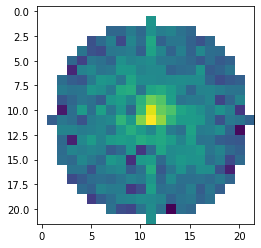

In [5]:
#### Apply mask
FT = fourier_transform(Fully_Sampled)
undersampled_FT = FT.copy()
undersampled_FT_uncombined = FT.copy()

for i in range(0,96):
    for j in range(0,8):
        for k in range(0,undersampled_FT.shape[-1]):
            undersampled_FT[:,:,:, i, j, k] = undersampled_FT[:,:,:, i, j, k] * masks[j]
            undersampled_FT_uncombined[:,:,:, i, j, k] = undersampled_FT_uncombined[:,:,:, i, j, k] * masks[0]

NN_input_uncombined = inverse_fourier_transform(undersampled_FT_uncombined)
NN_input_uncombined = NN_input_uncombined.astype(np.complex64)

NN_input_uncombined_complementary_masks = inverse_fourier_transform(undersampled_FT).astype(np.complex64)

filename = f'Undersampled_Data/Regular/AF_2/Complementary_Masks/data.npy'
#NN_input_uncombined_masked = apply_masks(NN_input_uncombined, MASKS)

np.save(filename, NN_input_uncombined_complementary_masks)

plt.imshow(np.log10(np.abs(undersampled_FT[:,:,10,0,0,0])))

# Construct the filename
if LowRank:
    filename = f'Undersampled_Data_P03-P08_LowRank/Undersampled_Regular.npy'
else:
    filename = f'Undersampled_Data/Regular/AF_2/One_Mask/data.npy'

# Only save if the file does not already exist
if not os.path.exists(filename):
    np.save(filename, NN_input_uncombined)
else:
    print(f"File '{filename}' already exists. Skipping save.")

In [6]:
### Alternative: Give mean average value of non-zero entries (from other time steps) to values that are 0

#FT = fourier_transform(ground_truth)     # (X, Y, Z, 96, 8, 2)
#undersampled_FT = FT.copy()

# If your 8 masks are in a list: masks[0], ..., masks[7], first stack them along axis=0
# so you have a single array of shape (8, X, Y, Z).
# e.g., masks_array = np.stack(masks, axis=0)

masks_array = np.stack(masks, axis=0)    # shape: (8, X, Y, Z)

# Loop over your extra dimensions (here: i in [0..96), k in [0..2))
for i in range(96):
    for k in range(undersampled_FT.shape[-1]):
        # Extract data across all 8 time steps at once
        # shape is (X, Y, Z, 8)
        data_slice = undersampled_FT[:, :, :, i, :, k]

        # Transpose so time dimension is first: shape becomes (8, X, Y, Z)
        data_slice_t = np.transpose(data_slice, (3, 0, 1, 2))

        # data_slice_t and masks_array now have matching shapes: (8, X, Y, Z)

        #---------------------------------------------------------------
        # 1) Calculate the mean over only the time steps where mask=1
        #---------------------------------------------------------------
        sum_vals   = np.sum(data_slice_t * masks_array, axis=0)  # shape (X, Y, Z)
        count_vals = np.sum(masks_array, axis=0)                 # shape (X, Y, Z)

        # Avoid dividing by zero (in case all time steps for a voxel are zero)
        mean_vals = sum_vals / np.maximum(count_vals, 1e-8)      # shape (X, Y, Z)

        #---------------------------------------------------------------
        # 2) Fill time steps that are zero in the mask with the mean
        #---------------------------------------------------------------
        # 2) Fill time steps that are zero in the mask with the mean
        zero_mask = (masks_array == 0)  # shape (8, X, Y, Z)

        # Expand mean_vals to (1, X, Y, Z)
        mean_vals_4d = mean_vals[None, ...]  # shape (1, X, Y, Z)

        # Broadcast to (8, X, Y, Z)
        mean_vals_4d = np.broadcast_to(mean_vals_4d, data_slice_t.shape)

        # Now assign where mask = 0
        data_slice_t[zero_mask] = mean_vals_4d[zero_mask]

        #---------------------------------------------------------------
        # 3) Put data back in the original (X, Y, Z, 8) layout
        #---------------------------------------------------------------
        data_slice_filled = np.transpose(data_slice_t, (1, 2, 3, 0))
        undersampled_FT[:, :, :, i, :, k] = data_slice_filled

# Now undersampled_FT has the "averaged fill" for zero-mask voxels
NN_input = inverse_fourier_transform(undersampled_FT)
NN_input = NN_input.astype(np.complex64)

#NN_input_combined_masked = apply_masks(NN_input, MASKS)

# Construct the filename
if LowRank:
    filename = f'Undersampled_Data_P03-P08_LowRank/Undersampled_Regular_Single_Combination.npy'
else:
    filename = f'Undersampled_Data/Regular/AF_2/Single_Combination/data.npy'

# Only save if the file does not already exist
if not os.path.exists(filename):
    np.save(filename, NN_input)
else:
    print(f"File '{filename}' already exists. Skipping save.")


File 'Undersampled_Data/Regular/AF_2/Single_Combination/data.npy' already exists. Skipping save.


Visualizing mask

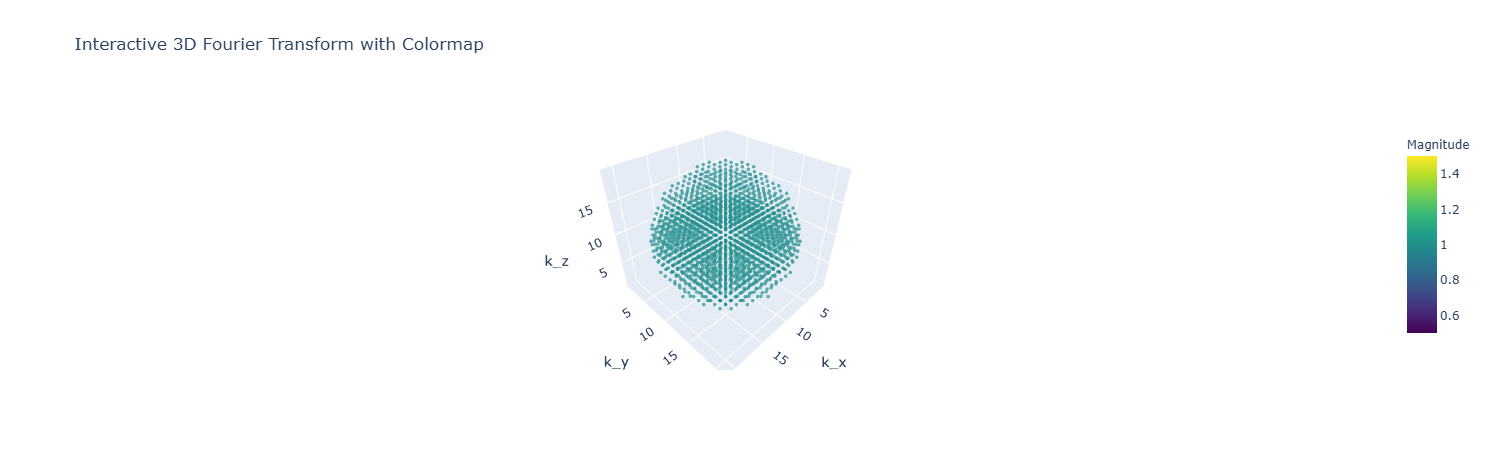

In [14]:
# Suppose 'mask' is your 3D array with 0/1 values.

MASK = masks[1]

# Get the indices for the full 3D grid
x, y, z = np.indices(MASK.shape)

# Flatten the arrays
x = x.flatten()
y = y.flatten()
z = z.flatten()
values = MASK.flatten()

# Filter out the 0 values — keep only those indices where values == 1
idx = np.where(values == 1)
x = x[idx]
y = y[idx]
z = z[idx]
values = values[idx]  # This will be all 1's now, but you might still want it for the colormap

# Create the 3D scatter plot
fig = go.Figure(
    data=go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=2,              # Adjust marker size
            color=values,        # All ones, but you can still pass it in if you want a colormap
            colorscale='Viridis',
            colorbar=dict(
                title="Magnitude",
                len=0.8
            ),
            opacity=0.7
        )
    )
)

# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title="k_x",
        yaxis_title="k_y",
        zaxis_title="k_z",
    ),
    title="Interactive 3D Fourier Transform with Colormap"
)

fig.show()

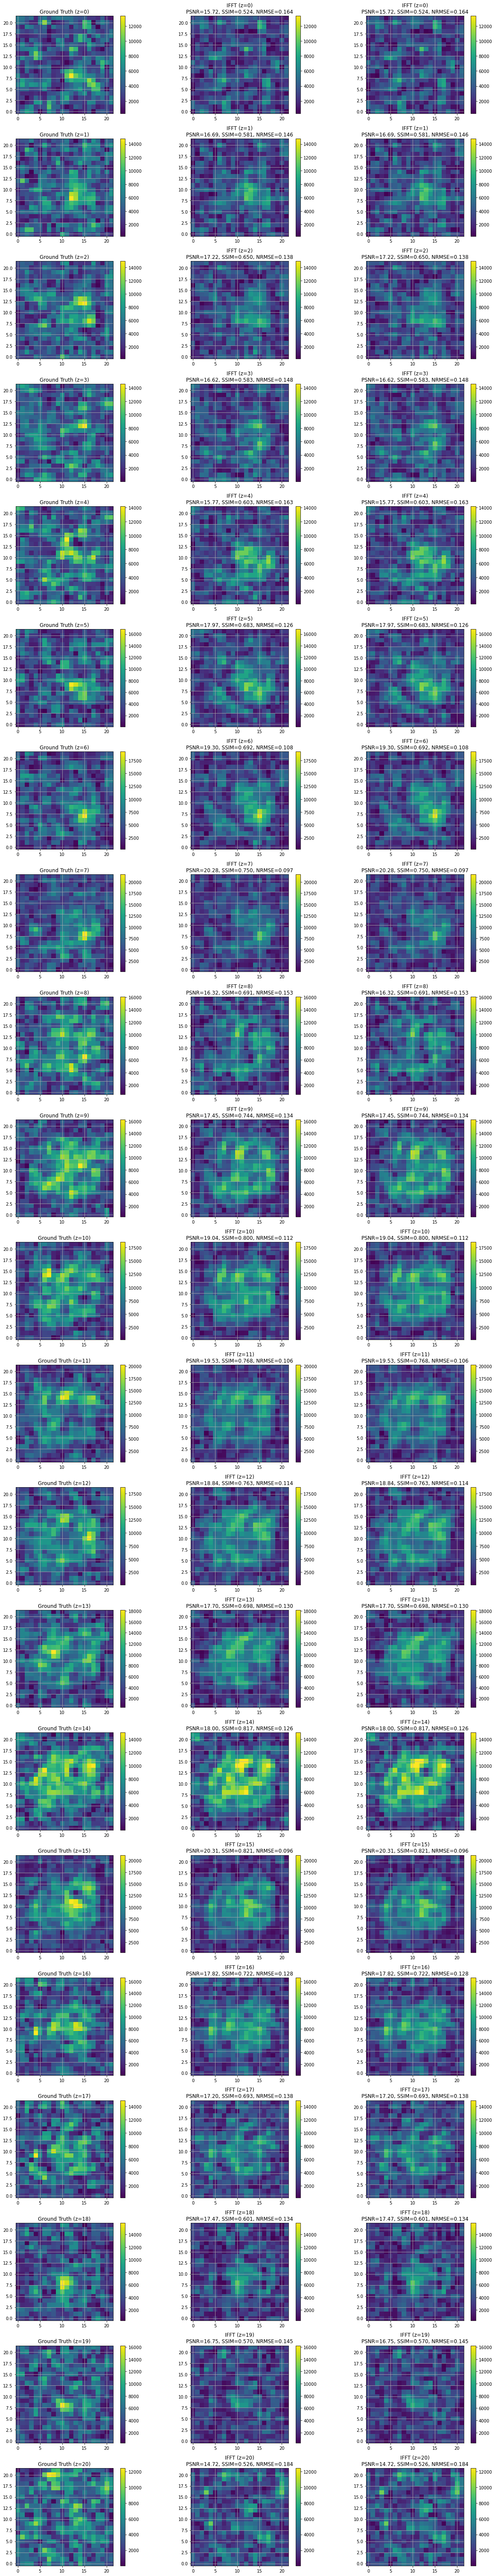

In [8]:
Patient = 4
label = "IFFT"

domain = "time"

t = 4 ##
T = 7

comparison_Plot_3D_vs_Ifft(NN_input_uncombined[...,Patient], Fully_Sampled[...,Patient], NN_input_uncombined[...,Patient], t, T, domain=domain, label = label)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

divide by zero encountered in log10



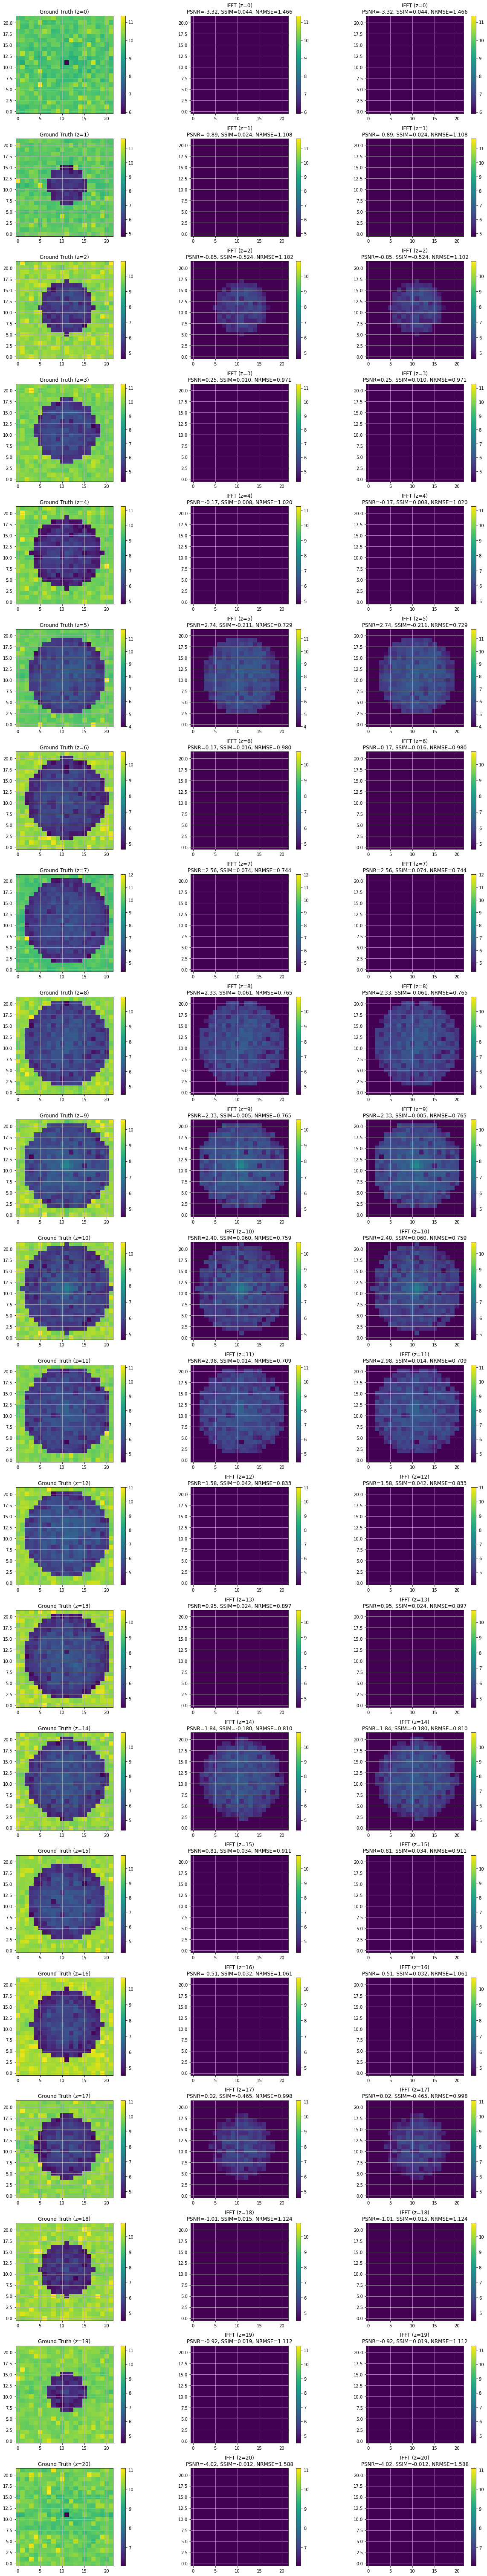

In [9]:
Patient = 4
label = "IFFT"

domain = "time"

NN_input_uncombined_FT = np.log10(np.abs(fourier_transform(NN_input_uncombined)))
Fully_Sampled_FT = np.log10(np.abs(fourier_transform(Fully_Sampled)))


t = 4
T = 7

comparison_Plot_3D_vs_Ifft(NN_input_uncombined_FT[...,Patient], Fully_Sampled_FT[...,Patient], NN_input_uncombined_FT[...,Patient], t, T, domain=domain, label = label)

# ***Undersampling error vs noise error***

**Estimate Signal P07**

    Signal ~ LowRank(Full_Rank_P07, 8)
    
**Estimate equivalent noise**

    noise_2 = Full_Rank_P08 - LowRank(Full_Rank_P08, 8)
    
    That the noise variances of P07 and P08 are basically identical: 11400789 (P07) and 11372949 (P08)
    
**Define noise equivalent ground truth 2:**

    ground_truth_2 = LowRank(Full_Rank_P07, 8) + noise_2

In [10]:
#Checked that noise variance of patient P08 and P07 agrees to more than 99%
Rank = 8

Ground_Truth_1 = Fully_Sampled[...,-2]

Signal = low_rank(Ground_Truth_1, Rank)

#### Generate physically equivalent ground truth, by taking the noise from the last patient; checkt that variance of both patiens agrees
#### to more than 99%!

noise_2 = Fully_Sampled[...,-1] - low_rank(Fully_Sampled[...,-1], Rank)

#### Generate equivalent ground truth

Ground_Truth_2 = Signal + noise_2

####Undersampled Ground_Truth_1
Undersampled = NN_input_uncombined[..., -2]


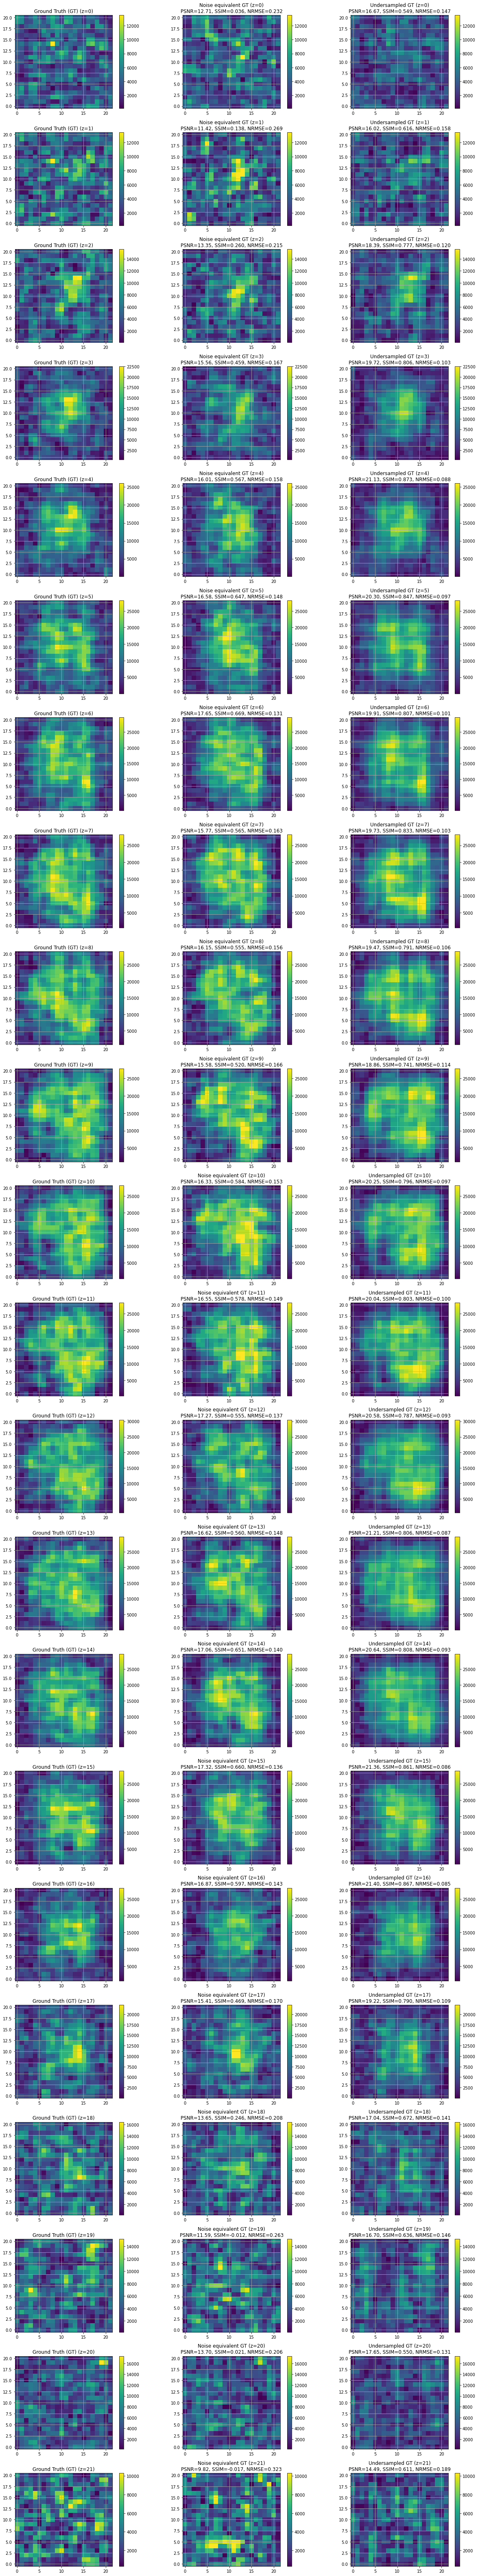

In [11]:
label = "Noise equivalent GT"
label2 = "Undersampled GT"
label3 = "Ground Truth (GT)"

domain = "time"

####print z-y instead of x-y to see aliasing artifacts
Ground_Truth_1_swapped = Ground_Truth_1.swapaxes(0, 2)
Ground_Truth_2_swapped = Ground_Truth_2.swapaxes(0, 2)
Undersampled_swapped = Undersampled.swapaxes(0, 2)

t = 2 # 50 water peak, ~60 Glc
T = 7

comparison_Plot_3D_vs_Ifft(Ground_Truth_2_swapped, Ground_Truth_1_swapped, Undersampled_swapped, t, T, domain=domain, label = label, label2 = label2, label3 = label3)

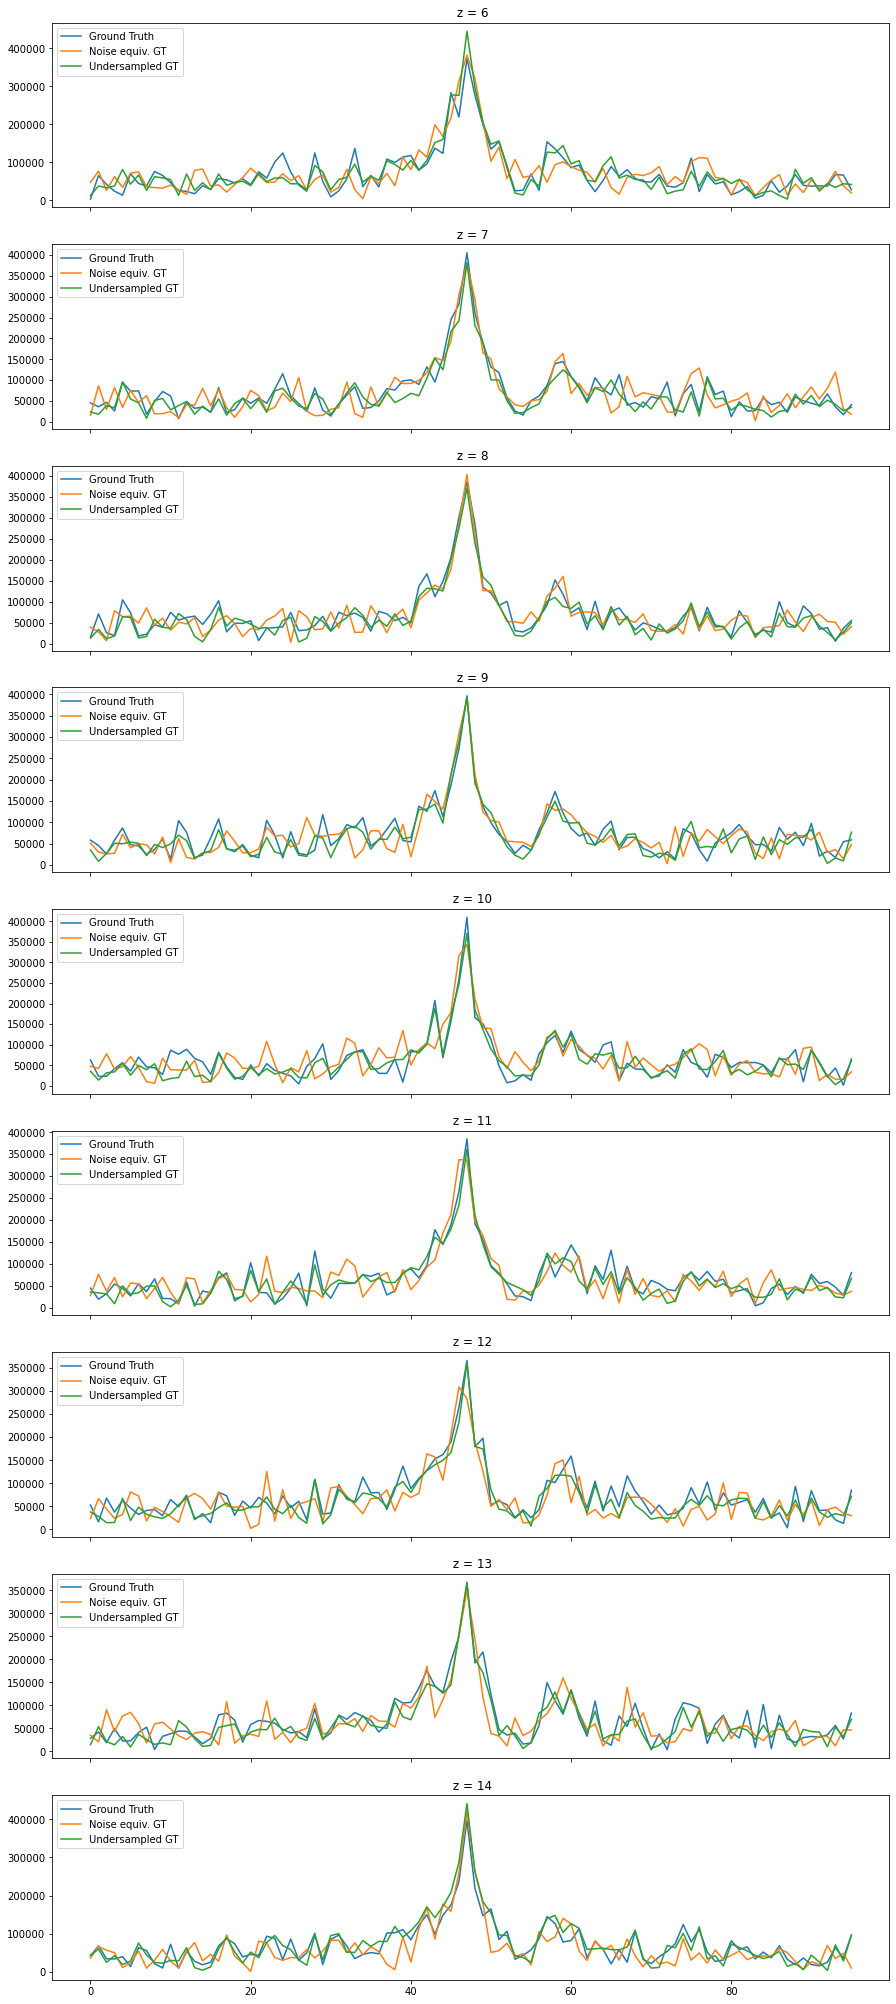

In [12]:
Patient = 0
x, y, T = 10, 15, 5

Ground_Truth_1_Spectral = np.fft.fftshift(np.fft.fft(Ground_Truth_1, axis=-2),axes=-2)
Ground_Truth_2_Spectral = np.fft.fftshift(np.fft.fft(Ground_Truth_2, axis=-2),axes=-2)
Undersampled_Spectral = np.fft.fftshift(np.fft.fft(Undersampled, axis=-2),axes=-2)

indices = range(6, 15) 
num_rows = len(indices)
num_cols = 1  # left column: arr1 vs arr2; right column: arr3 vs arr4
# Create a figure and a grid of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4), sharex=True)

# If there's only one row, axs may not be 2D, so ensure we have a 2D array:
if num_rows == 1:
    axs = np.array([axs])

for i, idx in enumerate(indices):
    # Left subplot: compare arr1 and arr2
    ax_left = axs[i]
    ax_left.plot(np.abs(Ground_Truth_1_Spectral[x, y, idx, :, T]), label="Ground Truth")
    ax_left.plot(np.abs(Ground_Truth_2_Spectral[x, y, idx, :, T]), label="Noise equiv. GT")
    ax_left.plot(np.abs(Undersampled_Spectral[x, y, idx, :, T]), label=f"Undersampled GT")
    ax_left.set_title(f" z = {idx}")
    ax_left.legend()
    ax_left.legend(loc="upper left")
    


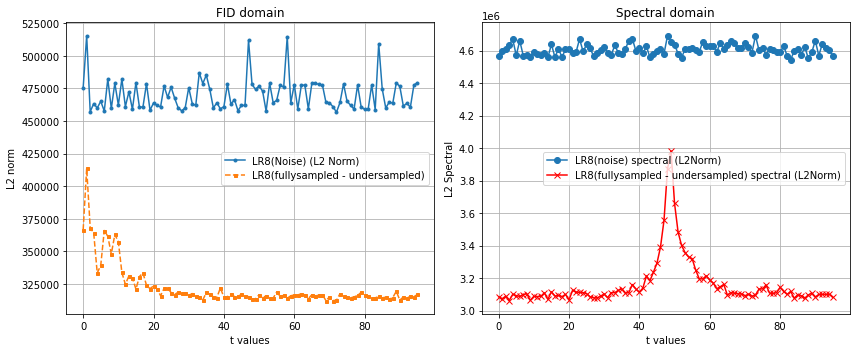

In [13]:
Patient = 0
AF = 3

Ground_Truth = Fully_Sampled
Undersampled_Data = NN_input_uncombined
#noise = Ground_Truth[...,Patient]-low_rank(Undersampled_Data[..., Patient], 8)
#noise = Ground_Truth[...,Patient]-low_rank(Undersampled_Data[..., Patient], 8)
noise = np.concatenate([Ground_Truth[:,:,:,66:,:,1], Ground_Truth[:,:,:,66:,:,2], Ground_Truth[:,:,:,66:,:,3], Ground_Truth[:,:,:,90:,:,4]], axis=3)  
axis_to_shuffle = 3
shuffled_indices = np.random.permutation(noise.shape[axis_to_shuffle])
noise = np.take(noise, shuffled_indices, axis=axis_to_shuffle)
 
LR8_noise = noise#low_rank(noise, 8)
LR8_undersampling_error = Ground_Truth[..., Patient]-Undersampled_Data[..., Patient]#low_rank(Ground_Truth[..., Patient]-Undersampled_Data[..., Patient], 8)

#### Also spectral domain
LR8_noise_spectral = np.fft.fftshift(np.fft.fft(LR8_noise, axis=-2), axes = -2)
LR8_undersampling_error_spectral = np.fft.fftshift(np.fft.fft(LR8_undersampling_error, axis=-2), axes = -2)

#### Compute 2 Norm of 3D volumes
LR8_noise_L2 = np.sqrt(np.sum(np.abs(LR8_noise)**2, axis=(0,1,2)))
LR8_undersampling_error_L2 = np.sqrt(np.sum(np.abs(LR8_undersampling_error)**2, axis=(0,1,2)))

LR8_noise_spectral_L2 = np.sqrt(np.sum(np.abs(LR8_noise_spectral)**2, axis=(0,1,2)))
LR8_undersampling_error_spectral_L2 = np.sqrt(np.sum(np.abs(LR8_undersampling_error_spectral)**2, axis=(0,1,2)))

#### Average over T
LR8_noise_L2 = np.mean(LR8_noise_L2, axis = -1)
LR8_undersampling_error_L2 = np.mean(LR8_undersampling_error_L2, axis = -1)

LR8_noise_spectral_L2 = np.mean(LR8_noise_spectral_L2, axis = -1)
LR8_undersampling_error_spectral_L2 = np.mean(LR8_undersampling_error_spectral_L2, axis = -1)

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Left subplot: Original two arrays
axes[0].plot(LR8_noise_L2, label='LR8(Noise) (L2 Norm)', linestyle='-', marker='o', markersize=3)
axes[0].plot(LR8_undersampling_error_L2, label='LR8(fullysampled - undersampled)', linestyle='--', marker='s', markersize=3)
axes[0].set_xlabel("t values")
axes[0].set_ylabel("L2 norm")
axes[0].set_title("FID domain")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Difference (Noise - Undersampling Error)
axes[1].plot(LR8_noise_spectral_L2, label='LR8(noise) spectral (L2Norm)', linestyle='-', marker='o')
axes[1].plot(LR8_undersampling_error_spectral_L2, label='LR8(fullysampled - undersampled) spectral (L2Norm)', linestyle='-', marker='x', color='r')
axes[1].set_xlabel("t values")
axes[1].set_ylabel("L2 Spectral")
axes[1].set_title("Spectral domain")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()